# DLA Point Cloud Visualization

This notebook provides tools for visualizing and analyzing 3D Diffusion-Limited Aggregation (DLA) point clouds exported from Blender.

## Features
- Interactive 3D visualization with Plotly
- Fractal dimension analysis using box-counting method
- Growth pattern analysis
- Animation support for time-series data

In [1]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path
import os

## 1. Load DLA Data

Load the exported DLA point cloud from Blender. Supports `.npz` format with positions, timepoints, and other attributes.

In [2]:
def load_dla_data(filepath):
    """
    Load DLA point cloud from NumPy .npz file.
    
    Returns:
        dict with positions, timepoints, colors, active, bounds, metadata
    """
    data = np.load(filepath, allow_pickle=True)
    
    result = {
        'positions': data['positions'],
        'timepoints': data.get('timepoints', np.zeros(len(data['positions']))),
        'colors': data.get('colors', np.zeros(len(data['positions']))),
        'active': data.get('active', np.zeros(len(data['positions']), dtype=bool)),
        'bounds': data.get('bounds', None),
    }
    
    # Get metadata
    for key in ['frame', 'total_frames', 'object_name', 'export_time']:
        if key in data:
            result[key] = data[key]
    
    return result

def load_ply_data(filepath):
    """
    Load DLA point cloud from PLY file.
    
    Returns:
        dict with positions and timepoints
    """
    positions = []
    timepoints = []
    colors = []
    
    with open(filepath, 'rb') as f:
        # Read header
        header_ended = False
        is_binary = False
        num_vertices = 0
        
        while not header_ended:
            line = f.readline().decode('ascii').strip()
            if line.startswith('format binary'):
                is_binary = True
            elif line.startswith('element vertex'):
                num_vertices = int(line.split()[-1])
            elif line == 'end_header':
                header_ended = True
        
        # Read data
        if is_binary:
            import struct
            for _ in range(num_vertices):
                data = struct.unpack('<fffff', f.read(20))
                positions.append(data[:3])
                timepoints.append(data[3])
                colors.append(data[4])
        else:
            for line in f:
                parts = line.decode('ascii').strip().split()
                if len(parts) >= 5:
                    positions.append([float(parts[0]), float(parts[1]), float(parts[2])])
                    timepoints.append(float(parts[3]))
                    colors.append(float(parts[4]))
    
    return {
        'positions': np.array(positions),
        'timepoints': np.array(timepoints),
        'colors': np.array(colors),
    }

In [3]:
# Load your exported DLA data
# Update this path to point to your exported file
DATA_PATH = "/tmp/dla_export.npz"  # or your custom path

# Check if file exists, otherwise create sample data
if os.path.exists(DATA_PATH):
    dla_data = load_dla_data(DATA_PATH)
    print(f"Loaded {len(dla_data['positions'])} points from {DATA_PATH}")
else:
    print(f"File not found: {DATA_PATH}")
    print("Creating sample DLA data for demonstration...")
    
    # Generate sample DLA-like data
    np.random.seed(42)
    n_points = 10000
    
    # Create branching structure
    positions = []
    timepoints = []
    
    # Seed point
    positions.append([0, 0, 0])
    timepoints.append(0)
    
    for i in range(1, n_points):
        # Random walk from a random existing point
        parent_idx = np.random.randint(0, len(positions))
        parent = np.array(positions[parent_idx])
        
        # Add small random displacement
        direction = np.random.randn(3)
        direction = direction / np.linalg.norm(direction) * 0.05
        
        new_pos = parent + direction
        positions.append(new_pos.tolist())
        timepoints.append(i / n_points * 250)  # Normalize to frame range
    
    dla_data = {
        'positions': np.array(positions),
        'timepoints': np.array(timepoints),
        'colors': np.random.rand(n_points),
        'active': np.zeros(n_points, dtype=bool),
    }
    
    print(f"Generated {n_points} sample points")

# Display info
positions = dla_data['positions']
timepoints = dla_data['timepoints']

print(f"\nData Summary:")
print(f"  Points: {len(positions)}")
print(f"  Position range:")
print(f"    X: [{positions[:,0].min():.3f}, {positions[:,0].max():.3f}]")
print(f"    Y: [{positions[:,1].min():.3f}, {positions[:,1].max():.3f}]")
print(f"    Z: [{positions[:,2].min():.3f}, {positions[:,2].max():.3f}]")
print(f"  Timepoint range: [{timepoints.min():.1f}, {timepoints.max():.1f}]")

File not found: /tmp/dla_export.npz
Creating sample DLA data for demonstration...
Generated 10000 sample points

Data Summary:
  Points: 10000
  Position range:
    X: [-0.266, 0.307]
    Y: [-0.274, 0.312]
    Z: [-0.314, 0.303]
  Timepoint range: [0.0, 250.0]


## 2. Interactive 3D Visualization

Create an interactive 3D scatter plot with timepoint-based coloring.

In [4]:
def visualize_dla_3d(positions, timepoints, title="DLA Point Cloud", 
                     colorscale='Viridis', point_size=1, opacity=0.8,
                     max_points=50000):
    """
    Create interactive 3D visualization of DLA point cloud.
    
    Args:
        positions: (N, 3) array of point coordinates
        timepoints: (N,) array of timepoint values for coloring
        title: Plot title
        colorscale: Plotly colorscale name
        point_size: Marker size
        opacity: Marker opacity
        max_points: Maximum points to display (for performance)
    
    Returns:
        Plotly figure
    """
    # Subsample if needed
    if len(positions) > max_points:
        indices = np.random.choice(len(positions), max_points, replace=False)
        positions = positions[indices]
        timepoints = timepoints[indices]
        print(f"Subsampled to {max_points} points for visualization")
    
    fig = go.Figure(data=[go.Scatter3d(
        x=positions[:, 0],
        y=positions[:, 1],
        z=positions[:, 2],
        mode='markers',
        marker=dict(
            size=point_size,
            color=timepoints,
            colorscale=colorscale,
            opacity=opacity,
            colorbar=dict(
                title="Frame",
                thickness=20,
            )
        ),
        hovertemplate=(
            "<b>Position</b><br>"
            "X: %{x:.3f}<br>"
            "Y: %{y:.3f}<br>"
            "Z: %{z:.3f}<br>"
            "Frame: %{marker.color:.0f}<br>"
            "<extra></extra>"
        )
    )])
    
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            font=dict(size=20)
        ),
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode='data',
            bgcolor='rgb(20, 20, 30)',
            xaxis=dict(gridcolor='gray', zerolinecolor='gray'),
            yaxis=dict(gridcolor='gray', zerolinecolor='gray'),
            zaxis=dict(gridcolor='gray', zerolinecolor='gray'),
        ),
        paper_bgcolor='rgb(30, 30, 40)',
        font=dict(color='white'),
        margin=dict(l=0, r=0, t=50, b=0),
        width=900,
        height=700,
    )
    
    return fig

In [5]:
# Create visualization
fig = visualize_dla_3d(
    dla_data['positions'],
    dla_data['timepoints'],
    title="3D DLA Point Cloud",
    colorscale='Viridis',
    point_size=2
)
fig.show()

## 3. Fractal Dimension Analysis

Estimate the fractal dimension using the box-counting method. For 3D DLA, the expected dimension is approximately D ≈ 2.5.

In [6]:
def box_counting_dimension(points, min_box=None, max_box=None, num_scales=20):
    """
    Estimate fractal dimension using box-counting method.
    
    Args:
        points: (N, 3) array of point coordinates
        min_box: Minimum box size (default: auto from point density)
        max_box: Maximum box size (default: bounding box diagonal)
        num_scales: Number of scales to sample
    
    Returns:
        dimension: Estimated fractal dimension
        scales: Array of box sizes used
        counts: Array of box counts at each scale
        r_squared: R² value of the linear fit
    """
    # Normalize points to [0, 1] range
    points_min = points.min(axis=0)
    points_max = points.max(axis=0)
    extent = (points_max - points_min).max()
    
    if extent == 0:
        return 0, [], [], 0
    
    normalized = (points - points_min) / extent
    
    # Set scale range
    if min_box is None:
        min_box = 0.01  # 1% of extent
    if max_box is None:
        max_box = 0.5  # 50% of extent
    
    scales = np.logspace(np.log10(min_box), np.log10(max_box), num_scales)
    counts = []
    
    for scale in scales:
        # Discretize points to grid
        grid_points = np.floor(normalized / scale).astype(np.int32)
        
        # Count unique boxes
        unique_boxes = len(set(map(tuple, grid_points)))
        counts.append(unique_boxes)
    
    counts = np.array(counts)
    
    # Linear regression on log-log plot
    log_scales = np.log(1 / scales)  # Use 1/scale for traditional box-counting
    log_counts = np.log(counts)
    
    # Remove invalid entries
    valid = np.isfinite(log_scales) & np.isfinite(log_counts)
    log_scales = log_scales[valid]
    log_counts = log_counts[valid]
    scales = scales[valid]
    counts = counts[valid]
    
    if len(log_scales) < 3:
        return 0, scales, counts, 0
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_scales, log_counts)
    
    return slope, scales, counts, r_value ** 2


def plot_box_counting_analysis(positions, title="Box-Counting Dimension Analysis"):
    """
    Create visualization of box-counting analysis.
    """
    dimension, scales, counts, r_squared = box_counting_dimension(positions)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Log-log plot
    ax1 = axes[0]
    ax1.loglog(1/scales, counts, 'bo-', markersize=8, label='Data')
    
    # Fit line
    log_x = np.log(1/scales)
    log_y = np.log(counts)
    slope, intercept = np.polyfit(log_x, log_y, 1)
    fit_y = np.exp(slope * log_x + intercept)
    ax1.loglog(1/scales, fit_y, 'r--', linewidth=2, 
               label=f'Fit: D = {dimension:.3f}')
    
    ax1.set_xlabel('1 / Box Size', fontsize=12)
    ax1.set_ylabel('Number of Boxes', fontsize=12)
    ax1.set_title('Box-Counting Analysis (Log-Log)', fontsize=14)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Residuals
    ax2 = axes[1]
    residuals = log_y - (slope * log_x + intercept)
    ax2.scatter(log_x, residuals, c='blue', alpha=0.7)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('log(1 / Box Size)', fontsize=12)
    ax2.set_ylabel('Residuals', fontsize=12)
    ax2.set_title(f'Residuals (R² = {r_squared:.4f})', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    
    return fig, dimension, r_squared


Fractal Dimension Results:
  Estimated D = 1.8550
  R² = 0.9759

  Expected for 3D DLA: D ≈ 2.5
  Difference from expected: 0.6450


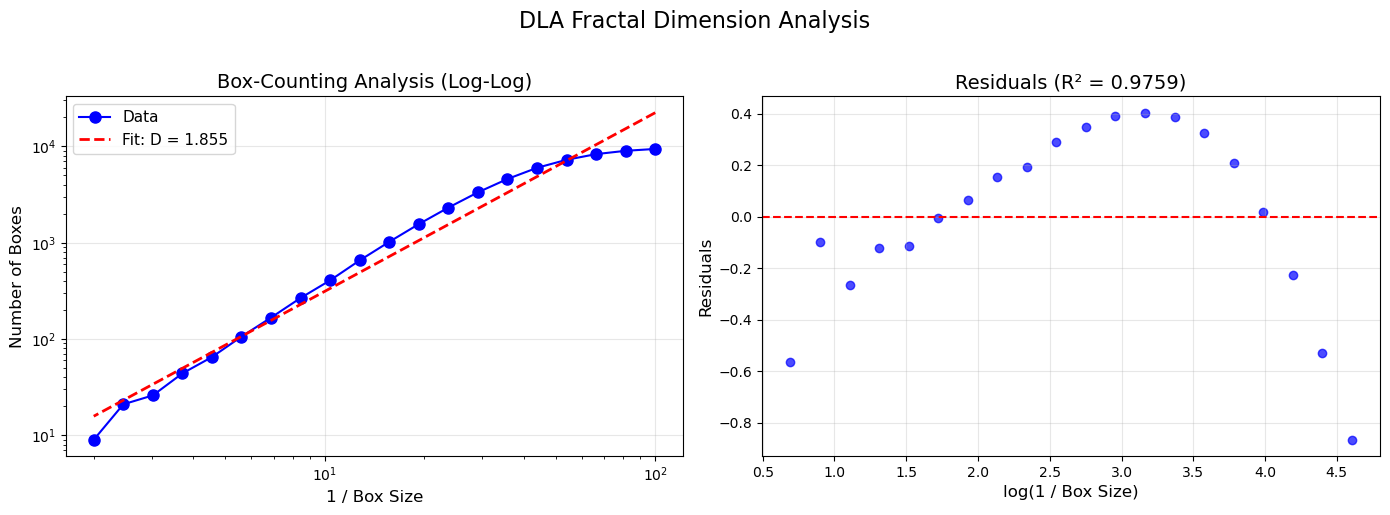

In [7]:
# Calculate fractal dimension
fig, dimension, r_squared = plot_box_counting_analysis(
    dla_data['positions'],
    title="DLA Fractal Dimension Analysis"
)

print(f"\nFractal Dimension Results:")
print(f"  Estimated D = {dimension:.4f}")
print(f"  R² = {r_squared:.4f}")
print(f"\n  Expected for 3D DLA: D ≈ 2.5")
print(f"  Difference from expected: {abs(dimension - 2.5):.4f}")

plt.show()

## 4. Growth Pattern Analysis

Analyze how the DLA structure grows over time.

In [8]:
def analyze_growth_pattern(positions, timepoints, num_bins=50):
    """
    Analyze DLA growth pattern over time.
    
    Returns metrics about growth rate, radius expansion, and density.
    """
    # Sort by timepoint
    order = np.argsort(timepoints)
    sorted_positions = positions[order]
    sorted_times = timepoints[order]
    
    # Calculate cumulative metrics
    results = {
        'time_bins': [],
        'particle_count': [],
        'max_radius': [],
        'mean_radius': [],
        'center_of_mass': [],
    }
    
    time_bins = np.linspace(sorted_times.min(), sorted_times.max(), num_bins + 1)
    
    for i in range(num_bins):
        t_start, t_end = time_bins[i], time_bins[i + 1]
        mask = sorted_times <= t_end
        
        if mask.sum() == 0:
            continue
        
        subset = sorted_positions[mask]
        
        # Calculate metrics
        radii = np.linalg.norm(subset, axis=1)
        center = subset.mean(axis=0)
        
        results['time_bins'].append((t_start + t_end) / 2)
        results['particle_count'].append(len(subset))
        results['max_radius'].append(radii.max())
        results['mean_radius'].append(radii.mean())
        results['center_of_mass'].append(center)
    
    # Convert to arrays
    for key in results:
        results[key] = np.array(results[key])
    
    return results


def plot_growth_analysis(growth_data):
    """
    Create multi-panel plot of growth analysis.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    time = growth_data['time_bins']
    
    # Particle count
    ax1 = axes[0, 0]
    ax1.plot(time, growth_data['particle_count'], 'b-', linewidth=2)
    ax1.fill_between(time, 0, growth_data['particle_count'], alpha=0.3)
    ax1.set_xlabel('Frame', fontsize=12)
    ax1.set_ylabel('Particle Count', fontsize=12)
    ax1.set_title('Cumulative Particle Count', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Radius expansion
    ax2 = axes[0, 1]
    ax2.plot(time, growth_data['max_radius'], 'r-', linewidth=2, label='Max Radius')
    ax2.plot(time, growth_data['mean_radius'], 'g--', linewidth=2, label='Mean Radius')
    ax2.set_xlabel('Frame', fontsize=12)
    ax2.set_ylabel('Radius', fontsize=12)
    ax2.set_title('Radius Expansion', fontsize=14)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # Growth rate (derivative of particle count)
    ax3 = axes[1, 0]
    growth_rate = np.gradient(growth_data['particle_count'], time)
    ax3.plot(time, growth_rate, 'm-', linewidth=2)
    ax3.set_xlabel('Frame', fontsize=12)
    ax3.set_ylabel('Growth Rate (particles/frame)', fontsize=12)
    ax3.set_title('Instantaneous Growth Rate', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    # Log-log plot of radius vs particles (for checking power law)
    ax4 = axes[1, 1]
    valid = (growth_data['max_radius'] > 0) & (growth_data['particle_count'] > 0)
    if valid.sum() > 2:
        log_r = np.log10(growth_data['max_radius'][valid])
        log_n = np.log10(growth_data['particle_count'][valid])
        
        ax4.scatter(log_n, log_r, c='blue', alpha=0.7)
        
        # Fit line
        slope, intercept = np.polyfit(log_n, log_r, 1)
        fit_x = np.array([log_n.min(), log_n.max()])
        fit_y = slope * fit_x + intercept
        ax4.plot(fit_x, fit_y, 'r--', linewidth=2, 
                label=f'Slope = {slope:.3f} (1/D ≈ {1/slope:.3f})')
        ax4.legend(fontsize=11)
    
    ax4.set_xlabel('log₁₀(Particle Count)', fontsize=12)
    ax4.set_ylabel('log₁₀(Max Radius)', fontsize=12)
    ax4.set_title('Power Law: R ~ N^(1/D)', fontsize=14)
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('DLA Growth Pattern Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    
    return fig

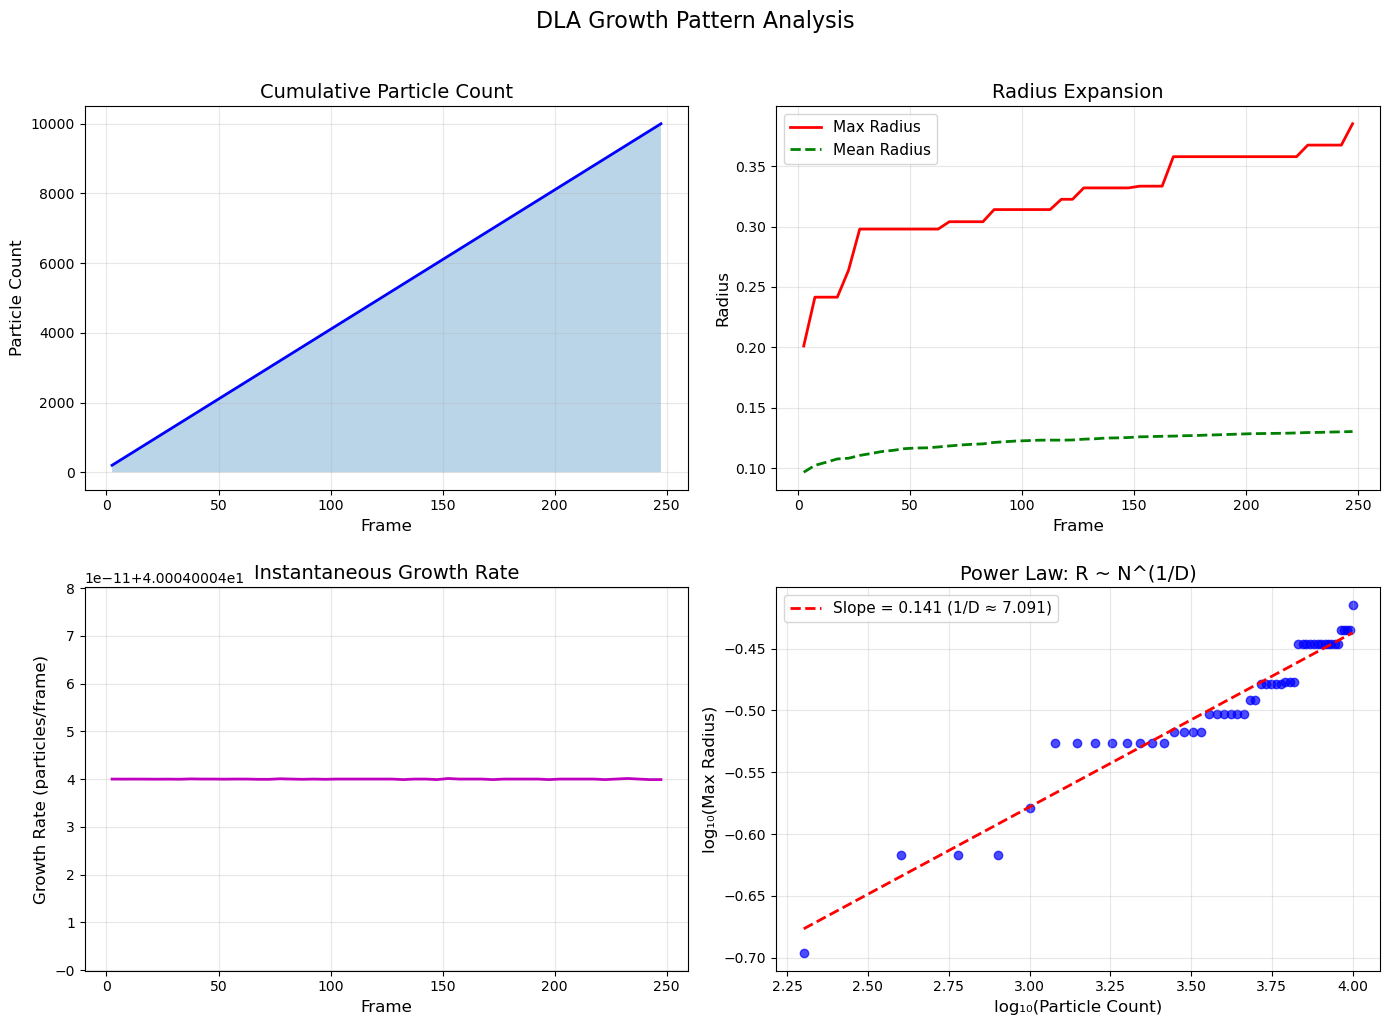


Growth Summary:
  Final particle count: 10000
  Final max radius: 0.3850
  Final mean radius: 0.1304


In [9]:
# Analyze growth pattern
growth_data = analyze_growth_pattern(
    dla_data['positions'],
    dla_data['timepoints']
)

fig = plot_growth_analysis(growth_data)
plt.show()

# Summary statistics
print("\nGrowth Summary:")
print(f"  Final particle count: {growth_data['particle_count'][-1]:.0f}")
print(f"  Final max radius: {growth_data['max_radius'][-1]:.4f}")
print(f"  Final mean radius: {growth_data['mean_radius'][-1]:.4f}")

## 5. Cross-Section Views

View 2D slices through the 3D structure.

In [10]:
def plot_cross_sections(positions, timepoints, slice_thickness=0.1):
    """
    Plot XY, XZ, and YZ cross-sections through the center of the structure.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    center = positions.mean(axis=0)
    
    # XY plane (Z ≈ center)
    mask_xy = np.abs(positions[:, 2] - center[2]) < slice_thickness
    axes[0].scatter(
        positions[mask_xy, 0], positions[mask_xy, 1],
        c=timepoints[mask_xy], cmap='viridis', s=1, alpha=0.8
    )
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].set_title(f'XY Plane (Z ≈ {center[2]:.2f})')
    axes[0].set_aspect('equal')
    axes[0].grid(True, alpha=0.3)
    
    # XZ plane (Y ≈ center)
    mask_xz = np.abs(positions[:, 1] - center[1]) < slice_thickness
    axes[1].scatter(
        positions[mask_xz, 0], positions[mask_xz, 2],
        c=timepoints[mask_xz], cmap='viridis', s=1, alpha=0.8
    )
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Z')
    axes[1].set_title(f'XZ Plane (Y ≈ {center[1]:.2f})')
    axes[1].set_aspect('equal')
    axes[1].grid(True, alpha=0.3)
    
    # YZ plane (X ≈ center)
    mask_yz = np.abs(positions[:, 0] - center[0]) < slice_thickness
    sc = axes[2].scatter(
        positions[mask_yz, 1], positions[mask_yz, 2],
        c=timepoints[mask_yz], cmap='viridis', s=1, alpha=0.8
    )
    axes[2].set_xlabel('Y')
    axes[2].set_ylabel('Z')
    axes[2].set_title(f'YZ Plane (X ≈ {center[0]:.2f})')
    axes[2].set_aspect('equal')
    axes[2].grid(True, alpha=0.3)
    
    # Colorbar
    plt.colorbar(sc, ax=axes, label='Frame', shrink=0.8)
    
    plt.suptitle('Cross-Section Views (2D Slices)', fontsize=14)
    plt.tight_layout()
    
    return fig

/tmp/ipykernel_1892294/3548740678.py:49: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



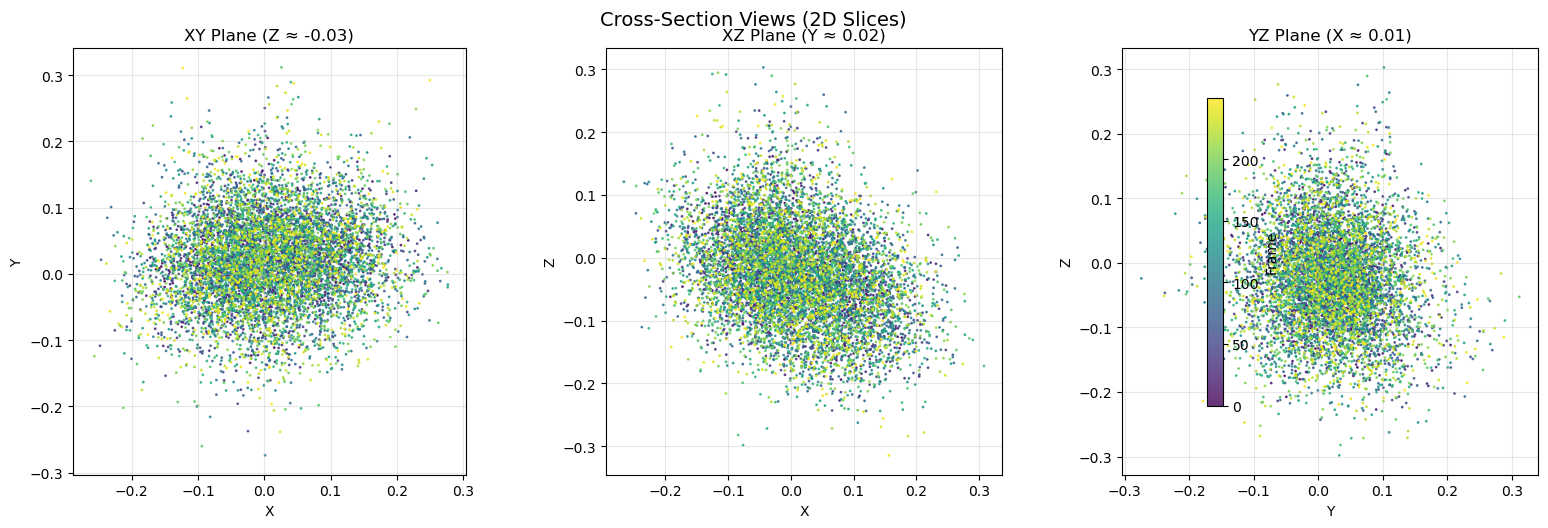

In [11]:
# Plot cross-sections
fig = plot_cross_sections(
    dla_data['positions'],
    dla_data['timepoints'],
    slice_thickness=0.1
)
plt.show()

## 6. Alternative Colorscales

Visualize with different color mappings to highlight different features.

In [12]:
# Create subplots with different colorscales
colorscales = ['Viridis', 'Plasma', 'Turbo', 'Hot']

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[f'{cs} Colorscale' for cs in colorscales],
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}],
           [{'type': 'scatter3d'}, {'type': 'scatter3d'}]]
)

# Subsample for performance
max_points = 10000
if len(dla_data['positions']) > max_points:
    indices = np.random.choice(len(dla_data['positions']), max_points, replace=False)
    pos = dla_data['positions'][indices]
    times = dla_data['timepoints'][indices]
else:
    pos = dla_data['positions']
    times = dla_data['timepoints']

for i, cs in enumerate(colorscales):
    row = i // 2 + 1
    col = i % 2 + 1
    
    fig.add_trace(
        go.Scatter3d(
            x=pos[:, 0],
            y=pos[:, 1],
            z=pos[:, 2],
            mode='markers',
            marker=dict(
                size=2,
                color=times,
                colorscale=cs,
                opacity=0.8,
            ),
            showlegend=False
        ),
        row=row, col=col
    )

fig.update_layout(
    height=800,
    width=1000,
    title_text="DLA Visualization with Different Colorscales",
    paper_bgcolor='rgb(30, 30, 40)',
    font=dict(color='white'),
)

# Update all scenes
for i in range(1, 5):
    scene_name = f'scene{i}' if i > 1 else 'scene'
    fig.update_layout(**{
        scene_name: dict(
            bgcolor='rgb(20, 20, 30)',
            aspectmode='data'
        )
    })

fig.show()

## 7. Export Analysis Results

Save analysis results for documentation or further processing.

In [13]:
def generate_analysis_report(dla_data, output_path=None):
    """
    Generate a comprehensive analysis report.
    """
    positions = dla_data['positions']
    timepoints = dla_data['timepoints']
    
    # Calculate all metrics
    dimension, scales, counts, r_squared = box_counting_dimension(positions)
    growth_data = analyze_growth_pattern(positions, timepoints)
    
    # Radial analysis
    radii = np.linalg.norm(positions, axis=1)
    
    report = {
        'basic_stats': {
            'total_points': len(positions),
            'bounds_min': positions.min(axis=0).tolist(),
            'bounds_max': positions.max(axis=0).tolist(),
            'center_of_mass': positions.mean(axis=0).tolist(),
        },
        'radial_stats': {
            'min_radius': float(radii.min()),
            'max_radius': float(radii.max()),
            'mean_radius': float(radii.mean()),
            'std_radius': float(radii.std()),
        },
        'fractal_analysis': {
            'box_counting_dimension': float(dimension),
            'r_squared': float(r_squared),
            'expected_dla_dimension': 2.5,
            'deviation_from_expected': float(abs(dimension - 2.5)),
        },
        'growth_metrics': {
            'final_particle_count': int(growth_data['particle_count'][-1]),
            'final_max_radius': float(growth_data['max_radius'][-1]),
            'final_mean_radius': float(growth_data['mean_radius'][-1]),
        }
    }
    
    # Print report
    print("=" * 60)
    print("DLA ANALYSIS REPORT")
    print("=" * 60)
    
    for section, data in report.items():
        print(f"\n{section.upper().replace('_', ' ')}:")
        for key, value in data.items():
            if isinstance(value, float):
                print(f"  {key}: {value:.6f}")
            elif isinstance(value, list):
                print(f"  {key}: [{', '.join(f'{v:.4f}' for v in value)}]")
            else:
                print(f"  {key}: {value}")
    
    print("\n" + "=" * 60)
    
    # Save to file if requested
    if output_path:
        import json
        with open(output_path, 'w') as f:
            json.dump(report, f, indent=2)
        print(f"Report saved to: {output_path}")
    
    return report

In [14]:
# Generate and display report
report = generate_analysis_report(dla_data)

DLA ANALYSIS REPORT

BASIC STATS:
  total_points: 10000
  bounds_min: [-0.2655, -0.2739, -0.3144]
  bounds_max: [0.3074, 0.3117, 0.3029]
  center_of_mass: [0.0091, 0.0207, -0.0275]

RADIAL STATS:
  min_radius: 0.000000
  max_radius: 0.385037
  mean_radius: 0.130387
  std_radius: 0.056912

FRACTAL ANALYSIS:
  box_counting_dimension: 1.854961
  r_squared: 0.975900
  expected_dla_dimension: 2.500000
  deviation_from_expected: 0.645039

GROWTH METRICS:
  final_particle_count: 10000
  final_max_radius: 0.385037
  final_mean_radius: 0.130387

